In [105]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf


In [106]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/NLP/data/ratings_train.txt", sep='\t')

In [109]:
print(df.shape)
df.head(3)

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [110]:
# pos, neg 비율
df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

## Missing 데이터 확인

In [111]:
# missing doc
sum(df['document'].isnull())

5

In [112]:
df = df[~df['document'].isnull()]

In [113]:
sum(df['document'].isnull())

0

# Tokenization

자연어를 모델이 이해하게 하기위해서는 자연어를 숫자의 형식으로 변형 시켜야한다.

In [114]:
df['document'].iloc[0].split()

['아', '더빙..', '진짜', '짜증나네요', '목소리']

In [115]:
# tokenization
vocab = set()
for doc in df['document']:
    for token in doc.split():
        vocab.add(token)
print(len(vocab))

357862


In [116]:
# tokenization
vocab_cnt_dict = {} 
for doc in df['document']:
    for token in doc.split():
        if token not in vocab_cnt_dict:
            vocab_cnt_dict[token] = 0
        vocab_cnt_dict[token] += 1

In [117]:
import numpy as np
vocab_cnt_list = [(token, cnt) for token, cnt in vocab_cnt_dict.items()]
top_vocabs = sorted(vocab_cnt_list, key=lambda tup:tup[1], reverse=True)
cnts = [cnt for _, cnt in top_vocabs]
cnts[:10]

[10825, 8239, 7791, 5929, 5059, 3598, 3285, 3260, 3249, 3237]

In [118]:
n_vocab = sum(np.array(cnts) > 2)
print(n_vocab)
top_vocabs_truncated = top_vocabs[:n_vocab]
top_vocabs_truncated[:10]

42635


[('영화', 10825),
 ('너무', 8239),
 ('정말', 7791),
 ('진짜', 5929),
 ('이', 5059),
 ('영화.', 3598),
 ('왜', 3285),
 ('더', 3260),
 ('이런', 3249),
 ('그냥', 3237)]

In [119]:
vocabs = [token for token, _ in top_vocabs_truncated]

## PAD token UNK token!

- UNK token은 Unknown token을 의미한다.
- PAD token은 Padding을 위한 token을 의미한다.

In [120]:
unk_token = '[UNK]'
unk_token in vocabs

False

In [121]:
pad_token = '[PAD]'
pad_token in vocabs

False

In [122]:
vocabs.insert(0, unk_token)
vocabs.insert(0, pad_token)

In [123]:
idx_to_token = vocabs
token_to_idx = {token: i for i, token in enumerate(idx_to_token)}
print(idx_to_token[:5])

['[PAD]', '[UNK]', '영화', '너무', '정말']


In [124]:
class Tokenizer:
    def __init__(self, vocabs, use_padding=True, max_padding=64, pad_token='[PAD]', unk_token='[UNK]'):
        self.idx_to_token = vocabs
        self.token_to_idx = {token: i for i, token in enumerate(self.idx_to_token)}
        
        self.use_padding = use_padding
        self.max_padding = max_padding
        
        self.pad_token = pad_token
        self.unk_token = unk_token
        
        self.unk_token_idx = self.token_to_idx[self.unk_token]
        self.pad_token_idx = self.token_to_idx[self.pad_token]
        
        
    def __call__(self, x):
        token_ids = []
        
        token_list = x.split()
        
        for token in token_list:
            if token in self.token_to_idx:
                token_idx = self.token_to_idx[token]
            else:
                token_idx = self.unk_token_idx
            token_ids.append(token_idx)
            
        if self.use_padding:
            token_ids = token_ids[:self.max_padding]
            n_pads = self.max_padding - len(token_ids)
            token_ids = token_ids + [self.pad_token_idx] * n_pads
        
        return token_ids
            

In [125]:
tokenizer = Tokenizer(vocabs, use_padding=False)

In [126]:
sample = df['document'].iloc[0]
print(sample)
tokenizer(sample)

아 더빙.. 진짜 짜증나네요 목소리


[51, 1, 5, 10485, 1064]

In [127]:
token_length_list = []
for sample in df['document']:
    token_length_list.append(len(tokenizer(sample)))

print(max(token_length_list))

41


In [128]:
tokenizer = Tokenizer(vocabs, use_padding=True, max_padding=50, pad_token='[PAD]', unk_token='[UNK]')

# DataLoader

In [129]:
import torch
from torch.utils.data import Dataset, DataLoader

In [130]:
# Split data into train, valid, testset

train_valid_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/NLP/data/ratings_train.txt", sep='\t')
test_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/NLP/data/ratings_test.txt", sep='\t')

In [131]:
print(f"# of train valid samples: {len(train_valid_df)}")
print(f"# of test samples: {len(test_df)}")

# of train valid samples: 150000
# of test samples: 50000


In [132]:
train_valid_df = train_valid_df.sample(frac=1.)

In [133]:
train_ratio = 0.8

n_train = int(len(train_valid_df) * train_ratio)

train_df = train_valid_df[:n_train]
valid_df = train_valid_df[n_train:]

In [134]:
print(f"# of train samples: {len(train_df)}")
print(f"# of train samples: {len(valid_df)}")
print(f"# of test samples: {len(test_df)}")

# of train samples: 120000
# of train samples: 30000
# of test samples: 50000


In [135]:
# 1/10으로 샘플링

train_df = train_df.sample(frac=0.1)
valid_df = valid_df.sample(frac=0.1)
test_df = test_df.sample(frac=0.1)

In [136]:
class NSMCDataset(Dataset):
    
    def __init__(self, data_df, tokenizer=None):
        self.data_df = data_df
        self.tokenizer = tokenizer
        
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        sample_raw = self.data_df.iloc[idx]
        sample = {}
        
        sample['doc'] = str(sample_raw['document'])
        sample['label'] = int(sample_raw['label'])
        
        assert sample['label'] in set([0, 1])
        
        if self.tokenizer is not None:
            sample['doc_ids'] = self.tokenizer(sample['doc']) 
        
        return sample        

In [137]:
def collate_fn(batch):
    keys = [key for key in batch[0].keys()]
    data = {key: [] for key in keys}

    for item in batch:
        for key in keys:
            data[key].append(item[key])
    return data

In [138]:
train_dataset = NSMCDataset(data_df=train_df, tokenizer=tokenizer)
valid_dataset = NSMCDataset(data_df=valid_df, tokenizer=tokenizer)
test_dataset = NSMCDataset(data_df=test_df, tokenizer=tokenizer)

# 학습 데이터셋은 shuffle을 해줘야함
train_dataloader= DataLoader(train_dataset,
                             batch_size=64,
                             collate_fn=collate_fn,
                             shuffle=True)

valid_dataloader= DataLoader(valid_dataset,
                             batch_size=64,
                             collate_fn=collate_fn,
                             shuffle=False)

test_dataloader= DataLoader(test_dataset,
                            batch_size=64,
                            collate_fn=collate_fn,
                            shuffle=False)

In [139]:
sample = next(iter(test_dataloader))

In [140]:
print(sample.keys())
sample['doc'][:10]

dict_keys(['doc', 'label', 'doc_ids'])


['내가 데스티네이션 시리즈 중 제일 재미없게 본게 2,4인데..같은 감독이었더라ㅡㅡ',
 '컴퓨터 그래픽 수준이 파워포스 레인져 수준 ㅋㅋㅋ황당하네',
 '야한장면 보다도 충격적인 결말이 훨씬 더 인상적이다. 브레야 감독 작품 중엔 가장 재미있고 대중적인 영화라고 생각함.',
 '그것이 바로 슈타인즈 게이트의 선택이다. 엘 프사이 콩그루',
 '영화춘향전을 고발한다. 연예가중계에서 정사신을 강요하며 욕하는 정일성촬영감독과 수치심에 울고 정사진을 소스라치며 거부하는 여자주인공의 영상을 봤다. 그리고 그상황을 고개돌려 외면하는 임권택감독. 16살 청소년에게 18금정사신을 찍게한 명백한 범죄다.',
 '마지막에 가스폭발하고 유리창 깨지면서 덥치는 장면 압권...',
 '액션영화로 기대하지말고 스릴러영화라 생각하고 보면 괜찮은 영화인듯^^',
 '편집이 볼만하다',
 '그래 이 영화가 높은 평점을 받을수없는건 이걸보고 불쾌감을 느낀 위선자들 때문이겠지 그 평점이 니들 클라스다 위선자들아',
 '멍청한 감독과 멍청한 배우가 만나면?']

# Self-attention model

In [141]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class SelfAttention(nn.Module):

    def __init__(self,
                 vocab_size,
                 embed_dim):
        """
        Args:
            vocab_size (int): size of vocabulary.
            embed_dim (int): dimension of embedding.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.output_dim = embed_dim

        self.embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, X, return_attention_score=False):
        """Feed-forward Self attention.
        Args:
            X (torch.Tensor): inputs, shape of (batch_size, seq_len).
        Returns:
            torch.tensor, Sentence representation.
        """
        batch_size, seq_len = X.size()
        X = self.embeddings(X) # batch size x seq_len x embed_dim
         
        q, k, v = self.q_linear(X), self.k_linear(X), self.v_linear(X) # batch_size x seq_len x embed_dim
        
        attention_score_raw = q @ k.transpose(1, 2) / math.sqrt(self.embed_dim) # batch_size x seq_len x seq_len
        
        attention_score = torch.softmax(attention_score_raw, dim=2) # batch_size x seq_len x seq_len
        
        weighted_sum = attention_score @ v # batch_size x seq_len x dim

        context = torch.mean(weighted_sum, dim=1) # self attention된 임베딩들을 average
        
        if return_attention_score:
            return context, attention_score
        return context
    
        

In [142]:
model = SelfAttention(len(vocabs), 16)
sample = next(iter(train_dataloader))
x = torch.tensor(sample['doc_ids'])
print('x shape: ', x.shape)
print('zero index value ',x[0])
pred = model(x)
print('pred shape: ', pred.shape)

x shape:  torch.Size([64, 50])
zero index value  tensor([26031,   142,  6492,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
pred shape:  torch.Size([64, 16])


In [143]:
class Classifier(nn.Module):
    """A classifier, arbitary graph, on the top of sentence representation.
    Attributes:
        sr_model: A sentence representation module.
        input_dim: Input dimension of the classifier. Input_dim is set with sr_model output.
        output_dim: Output dimension of the model.
    """
    def __init__(self, sr_model, output_dim, vocab_size, embed_dim, **kwargs):
        """Initialization of the classifier.
        
        Args:
            sr_model (torch.nn.Module): A sentence representation module.
            output_dim (int): Output dimension of the model.
            vocab_size (int): The size of vocabulary.
            embed_dim (int): The word embedding dimension.
        """
        super().__init__()

        self.sr_model = sr_model(vocab_size=vocab_size,
                                 embed_dim=embed_dim,
                                 **kwargs)

        self.input_dim = self.sr_model.output_dim
        self.output_dim = output_dim
        self.fc = nn.Linear(self.input_dim, self.output_dim)

    def forward(self, x):
        return self.fc(self.sr_model(x))

In [144]:
model = Classifier(sr_model=SelfAttention,
                   output_dim=2,
                   vocab_size=len(vocabs),
                   embed_dim=16)

In [145]:
# nn.Embedding(vocab_size, embed_dim, padding_idx=0)
# padding_idx를 설정해놓으면,
# padding_idx의 embedding은 0으로 초기화
# padding index의 embedding은 gradient 계산을 하지 않음, 즉 padding embedding은 업데이트 되지 않음

model.sr_model.embeddings.weight[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)

# Training

In [146]:
use_cuda = True and torch.cuda.is_available()

if use_cuda:
    model.cuda()

In [147]:
import torch.optim as optim
import numpy as np
from copy import deepcopy

In [148]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01)
calc_loss = nn.CrossEntropyLoss()

In [149]:
n_epoch = 5
global_i = 0

valid_loss_history = [] # [(global_i, valid_loss), ...]
train_loss_history = [] # [(global_i, train_loss), ...]

min_valid_loss = 9e+9
best_model = None
best_epoch_i = None

for epoch_i in range(n_epoch):
    model.train()
    
    for batch in train_dataloader:
        optimizer.zero_grad()
        x = torch.tensor(batch['doc_ids'])
        y = torch.tensor(batch['label'])

        if use_cuda:
            x = x.cuda()
            y = y.cuda()

        y_pred = model(x)
        loss = calc_loss(y_pred, y)

        if global_i % 1000 == 0:
            print(f"global_i: {global_i}, epoch_i: {epoch_i}, loss: {loss.item()}")
            
        train_loss_history.append((global_i, loss.item()))
            
        loss.backward()
        optimizer.step()
            
        global_i += 1
    # validation
    model.eval()
    valid_loss_list = []
    for batch in valid_dataloader:
        x = torch.tensor(batch['doc_ids'])
        y = torch.tensor(batch['label'])

        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        y_pred = model(x)
        loss = calc_loss(y_pred, y)
        valid_loss_list.append(loss.item())


    valid_loss_mean = np.mean(valid_loss_list)
    valid_loss_history.append((global_i, valid_loss_mean.item()))


    if valid_loss_mean < min_valid_loss:
        min_valid_loss = valid_loss_mean
        best_epoch_i = epoch_i
        best_model = deepcopy(model)

    if epoch_i % 1 == 0:
        print("*"*30)
        print(f"valid_loss_mean: {valid_loss_mean}")
        print("*"*30)
    
print(f"best_epoch_i: {best_epoch_i}, best_global_i: {global_i}")

global_i: 0, epoch_i: 0, loss: 0.693378210067749
******************************
valid_loss_mean: 0.6060351704029326
******************************
******************************
valid_loss_mean: 0.5988255339734098
******************************
******************************
valid_loss_mean: 0.6721749952498902
******************************
******************************
valid_loss_mean: 0.8426426813957539
******************************
******************************
valid_loss_mean: 1.0403972420286625
******************************
best_epoch_i: 1, best_global_i: 940


# Learning Curve

In [150]:
def calc_moving_average(arr, win_size=100):
    new_arr = []
    win = []
    
    for i, val in enumerate(arr):
        win.append(val)
        if len(win) > win_size:
            win.pop(0)
        
        new_arr.append(np.mean(win))
    return np.array(new_arr)

Text(0, 0.5, 'loss')

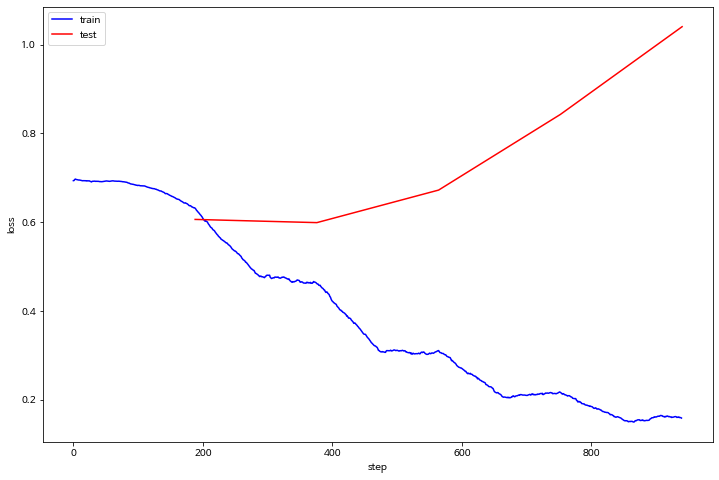

In [151]:
valid_loss_history = np.array(valid_loss_history)
train_loss_history =  np.array(train_loss_history)

plt.figure(figsize=(12,8))
plt.plot(train_loss_history[:,0],
         calc_moving_average(train_loss_history[:,1]), color='blue')

plt.plot(valid_loss_history[:,0],
         valid_loss_history[:,1], color='red')
plt.legend(['train','test'])
plt.xlabel("step")
plt.ylabel("loss")

# Evaluation

In [152]:
from tqdm.auto import tqdm

In [153]:
model = best_model

model.eval()

total = 0
correct = 0
for batch in tqdm(test_dataloader,
                  total=len(test_dataloader.dataset)//test_dataloader.batch_size):
    x = torch.tensor(batch['doc_ids'])
    y = torch.tensor(batch['label'])
    
    if use_cuda:
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x)
    
    curr_correct = y_pred.argmax(dim=1) == y
    
    total += len(curr_correct)
    correct += sum(curr_correct)
print(f"test accuracy: {correct/total}")

  0%|          | 0/78 [00:00<?, ?it/s]

test accuracy: 0.6990000009536743


# Visualize Attention

In [154]:
sample = df['document'].iloc[14]
print(sample)

취향은 존중한다지만 진짜 내생에 극장에서 본 영화중 가장 노잼 노감동임 스토리도 어거지고 감동도 어거지


In [155]:
tokenizer.use_padding = False
token_ids = tokenizer(sample)

In [156]:
token_ids = torch.tensor(token_ids)
if use_cuda:
    token_ids = token_ids.cuda()

In [157]:
token_list = [idx_to_token[token_idx] for token_idx in token_ids]

In [158]:
list(zip(token_list, token_ids))

[('취향은', tensor(3213, device='cuda:0')),
 ('[UNK]', tensor(1, device='cuda:0')),
 ('진짜', tensor(5, device='cuda:0')),
 ('내생에', tensor(1742, device='cuda:0')),
 ('극장에서', tensor(215, device='cuda:0')),
 ('본', tensor(21, device='cuda:0')),
 ('영화중', tensor(257, device='cuda:0')),
 ('가장', tensor(54, device='cuda:0')),
 ('노잼', tensor(543, device='cuda:0')),
 ('[UNK]', tensor(1, device='cuda:0')),
 ('스토리도', tensor(132, device='cuda:0')),
 ('[UNK]', tensor(1, device='cuda:0')),
 ('감동도', tensor(287, device='cuda:0')),
 ('어거지', tensor(4777, device='cuda:0'))]

In [159]:
token_ids.reshape(1,-1).shape

torch.Size([1, 14])

In [160]:
# Attention score 계산
_, attention_score = model.sr_model(token_ids.reshape(1,-1), return_attention_score=True)

In [161]:
attention_score_np = attention_score.squeeze(0).detach().cpu().numpy()

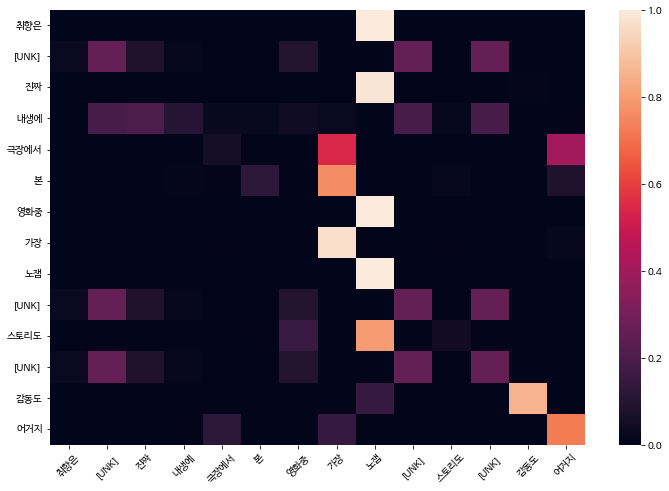

In [162]:
import seaborn as sns

plt.figure(figsize=(12,8))
attn_vis = sns.heatmap(attention_score_np, xticklabels=token_list, yticklabels=token_list)
_ = attn_vis.set_xticklabels(attn_vis.get_xticklabels(), rotation=45)